# 01. Data preparation

1. Load raw dataframes
2. Select relevant columns
3. *Normalize per team*
4. *Cluster team data*
5. Combine with FM data

**Normalize per team:**

We will normalize stats per each team. The point is that a defensive player of a stronger team might have more attacking stats than an attacking player of a weaker team just because of overall possession and tactics. Team information would be passed as a cluster type, but for the purpose of stats analysis it is best to have information about a player from within the team, how important their contribution is for the team

**Cluster team data:**

Mean statistics grouped by team would be used to cluster teams. The cluster will then be used as a feature to evaluate players

In [34]:
# change wd to repo home
import os
if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

In [35]:
import pandas as pd

## Combine all FBRef data into one dataframe

In [36]:
# load FBRef data in separate dfs
fbref_dfs = {filename : pd.read_csv(f'data/FBRef_split/{filename}', index_col=0)
             for filename in os.listdir('data/FBRef_split')}

In [37]:
# combine FBRef dfs by type first
table_types = ['defense', 'gca', 'keepersadv', 'keepers', 'misc', 'passingtypes',
               'passing', 'playingtime', 'possession', 'shooting', 'stats']

fbref_dfs_types = {}

for t in table_types:
    fbref_dfs_types[t] = {}
    for k in fbref_dfs.keys():
        if k.split('_')[1] == t:
            fbref_dfs_types[t][k.split('_')[0]] = fbref_dfs[k]
    fbref_dfs_types[t] = pd.concat(fbref_dfs_types[t], axis=0, ignore_index=True).set_index(['_Player', '_Squad', '_Born'])

In [38]:
# combine FBRef dfs into one
fbref_combined_df = pd.concat(fbref_dfs_types, axis=1).reset_index()
fbref_combined_df.columns = fbref_combined_df.columns.map(lambda x: '_'.join(map(str, x)))

In [39]:
# store a complete FBRef file
fbref_combined_df.to_csv('data/FBRef_combined.csv')

## Select relevant columns

In [40]:
# select columns
FM_columns = ['Name', 'Position', 'Corners', 'Crossing', 'Dribbling', 'Finishing', 'First Touch',
              'Free Kick Taking', 'Heading', 'Long Shots', 'Long Throws', 'Marking', 'Passing',
              'Penalty Taking', 'Tackling', 'Technique', 'Aggressiion', 'Anticipation', 'Bravery',
              'Composure', 'Concentration', 'Vision', 'Decision', 'Determination', 'Flair', 'Leadership',
              'Off The Ball', 'Teamwork', 'Work Rate', 'Positioning', 'Acceleration', 'Agility', 'Balance',
              'Jumping Reach', 'Natural Fitness', 'Pace', 'Stamina', 'Strength']
defense_columns = ['defense_Blocks_Blocks', 'defense_Tackles_Tkl', 'defense_Tackles_TklW',
                   'defense_Tackles_Def 3rd', 'defense_Tackles_Mid 3rd', 'defense_Tackles_Att 3rd',
                   'defense__Int', 'defense__Clr']
touches_columns = ['possession_Touches_Def Pen', 'possession_Touches_Def 3rd', 'possession_Touches_Mid 3rd',
                   'possession_Touches_Att 3rd', 'possession_Touches_Att Pen', 'possession_Touches_Touches']
passing_columns = ['passing_Total_Att', 'passing_Short_Att', 'passing_Medium_Att', 'passing_Long_Att',
                   'passing__KP', 'passing__CrsPA', 'passing__PrgP']
progres_columns = ['possession_Carries_PrgDist', 'possession_Carries_TotDist', 'possession_Receiving_Rec',
                   'possession_Receiving_PrgR', 'possession_Take-Ons_Att', 'possession_Take-Ons_Succ']
attack_columns = ['gca_SCATypes_TO', 'gca_SCATypes_Sh', 'gca_SCATypes_Fld', 'gca_SCATypes_Def',
                  'gca_SCATypes_PassLive', 'gca_SCATypes_PassDead', 'shooting_Standard_Dist',
                  'shooting_Expected_npxG']
misc_columns = ['playingtime_PlayingTime_Min', 'misc_Performance_Fls', 'misc_Performance_Fld',
                'misc_Performance_Off', 'misc_AerialDuels_Won', 'misc_AerialDuels_Lost']

In [41]:
all_stats_columns = (defense_columns + touches_columns + passing_columns +
                     progres_columns + attack_columns + misc_columns)

## Normalize each column selection by team

In [42]:
from sklearn.preprocessing import MinMaxScaler

Drop players with fewer than 500 minutes

In [43]:
fbref_combined_filtered_df = fbref_combined_df[fbref_combined_df['playingtime_PlayingTime_Min']>=500]

In [44]:
# function to apply Min-Max scaling based on selected group and per-90 minutes stats
def minmax_scaling(group):
    scaler = MinMaxScaler()
    # Divide each column by 'playingtime_PlayingTime_Min' except for 'playingtime_PlayingTime_Min' itself
    for column in all_stats_columns:
        if column != 'playingtime_PlayingTime_Min' and column in group.columns:
            group[column] = group[column] / group['playingtime_PlayingTime_Min']
    # Apply Min-Max scaling
    group[all_stats_columns] = scaler.fit_transform(group[all_stats_columns])
    return group

In [45]:
fbref_normalized_df = fbref_combined_filtered_df.groupby('_Squad_', as_index=False).apply(minmax_scaling)

## Cluster teams

In [46]:
fbref_teams_df = fbref_combined_filtered_df.groupby('_Squad_')[all_stats_columns].mean()

In [47]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [48]:
team_scaler = StandardScaler()
fbref_teams_scaled = team_scaler.fit_transform(fbref_teams_df.values)

In [49]:
import seaborn as sns

n_clusters = {}
for k in range(1,11):
    team_clusters_kmeans = KMeans(n_clusters=k)
    team_clusters_kmeans.fit(fbref_teams_scaled)
    n_clusters[k] = team_clusters_kmeans.inertia_

c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a

<Axes: >

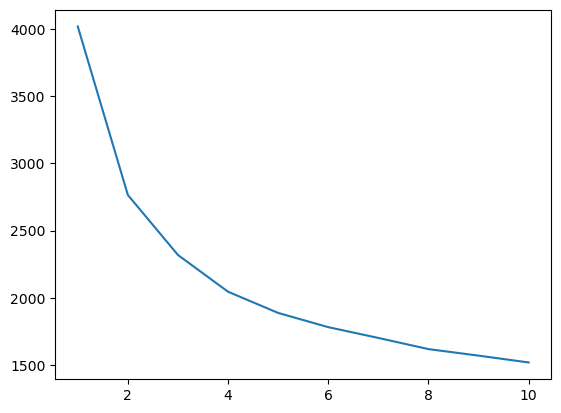

In [50]:
sns.lineplot(n_clusters)

In [51]:
team_clusters_kmeans = KMeans(n_clusters=4)

team_clusters = team_clusters_kmeans.fit_predict(fbref_teams_scaled)

fbref_teams_df['cluster'] = team_clusters

c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [52]:
fbref_normalized_df['team_cluster'] = fbref_teams_df.loc[fbref_normalized_df.loc[:, '_Squad_'], 'cluster'].values

C:\Users\alibe\AppData\Local\Temp\ipykernel_35196\1139446809.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fbref_normalized_df['team_cluster'] = fbref_teams_df.loc[fbref_normalized_df.loc[:, '_Squad_'], 'cluster'].values


In [56]:
fbref_normalized_df.reset_index(inplace=True, drop=True)

## Combine with FM data

In [58]:
# drop keepers
fbref_normalized_outfielders_df = fbref_normalized_df[fbref_normalized_df['stats__Pos']!='GK']

In [59]:
# load FM data
FM_data = pd.read_csv('./data/FM 2023.csv')

In [69]:
# combine the two dataframes
combined_data = fbref_normalized_outfielders_df.drop_duplicates('_Player_').merge(right=FM_data, left_on='_Player_', right_on='Name', how='inner')
combined_data = combined_data[['_Player_', 'team_cluster'] + all_stats_columns + FM_columns]

In [71]:
# store the combined file
combined_data.to_csv('data/combined_data.csv')